## Data Exploration ##

In [1]:
# !pip install sklearn
# !pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

Import the dataset:

In [3]:
file_path = "../dataset/dataset.csv"    # In the git hub repository, the dataset is in the dataset folder: https://github.com/EdoardoZappia/Fraud-Detection-with-QML/blob/main/dataset/dataset.csv

Read the dataset into a DataFrame using Pandas

In [4]:
try:
    df = pd.read_csv(file_path)
    print("Dataset imported successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
    exit()


Dataset imported successfully.


- Histogram of transaction amounts

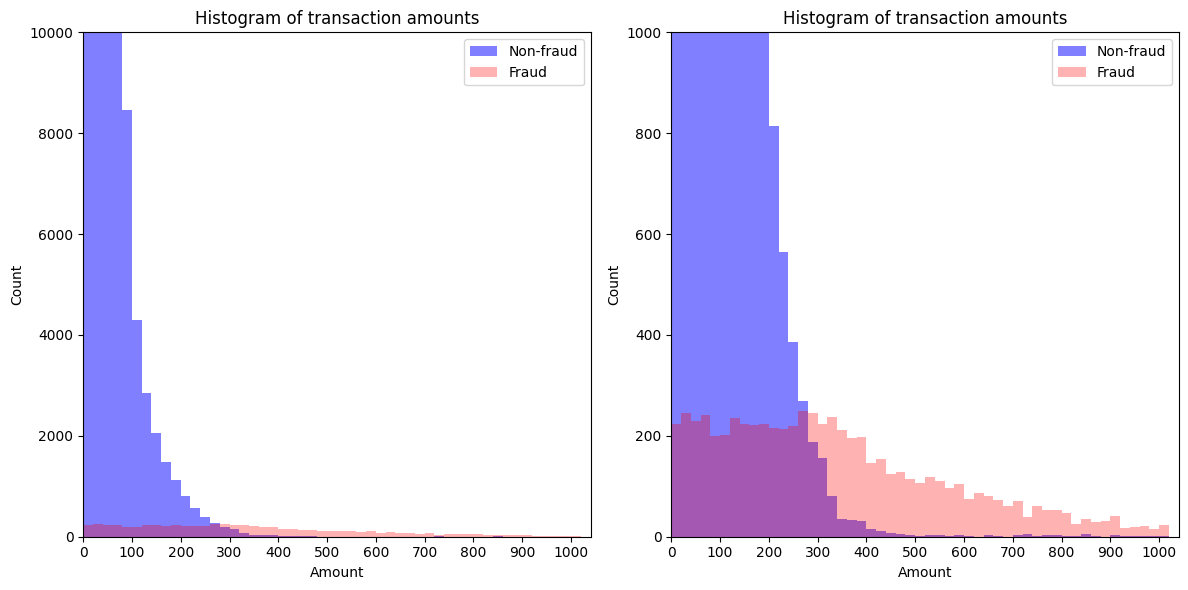

In [5]:
bin_edges = range(0, 1040, 20)
amount_fraud_0 = df[df['fraud'] == 0]['amount']
amount_fraud_1 = df[df['fraud'] == 1]['amount']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(amount_fraud_0, bins=bin_edges, color='blue', alpha=0.5)
axes[0].hist(amount_fraud_1, bins=bin_edges, color= 'red', alpha=0.3)

axes[0].set_title('Histogram of transaction amounts')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Count')
axes[0].set_xlim(0, 1040)
axes[0].set_ylim(0, 10000)
axes[0].set_xticks(range (0, 1040, 100))

axes[1].hist(amount_fraud_0, bins=bin_edges, color='blue', alpha=0.5)
axes[1].hist(amount_fraud_1, bins=bin_edges, color= 'red', alpha=0.3)
axes[1].set_title('Histogram of transaction amounts')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Count')
axes[1].set_xlim(0, 1040)
axes[1].set_ylim(0, 1000)
axes[1].set_xticks(range (0, 1040, 100))

#Legend
axes[0].legend(['Non-fraud', 'Fraud'], loc='upper right')
axes[1].legend(['Non-fraud', 'Fraud'], loc='upper right')

# Adjust layout
plt.tight_layout()

In [6]:
# Save the figure
#plt.savefig('Histogram of transaction amounts.png')

As we can see by the graph the fraudolent transactions are more frequent in the lower amounts, 
while the non-fraudolent transactions are more frequent in the higher amounts. So we can see the
fraudolent transactions as outliers of the amount feature.
So we expect the amount of transactions to be an important feature to predict the response variable.

- Bar plot of fraudulent payments by age category

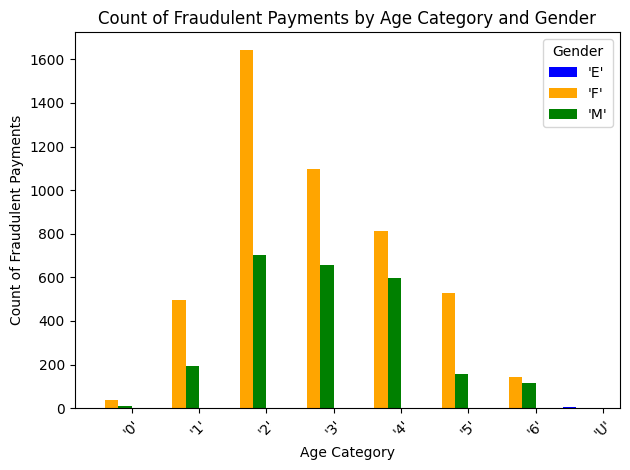

In [7]:
fraud_count = df[df['fraud'] == 1].groupby(['age', 'gender']).size().unstack(fill_value=0)

# Plot the bar plot
fraud_count.plot(kind='bar', stacked=False, position=1, width=0.6, color=['blue', 'orange', 'green'])
plt.title('Count of Fraudulent Payments by Age Category and Gender')
plt.xlabel('Age Category')
plt.ylabel('Count of Fraudulent Payments')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()

In [8]:
# Save the figure
#plt.savefig('Count of Fraudulent Payments by Age Category and Gender.png')

We can see that the most affecting age categories to fraudolent transactions are 26-35, 36-45 and 46-55.
We can expect that result considering that those age categories are the most probable to do transactions.
Females are constitute more fraudolent transactions.

Since it's not clear, we will do further analysis to understand the relationship between gender, age and fraudolent transactions.

- Bar plot of fraudulent payments by merchant category


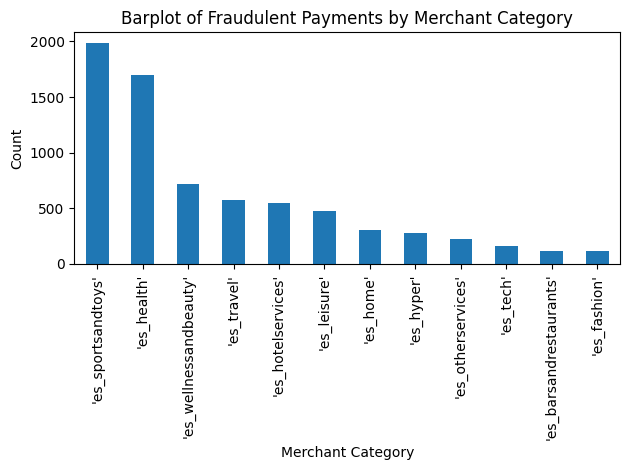

In [9]:
df_fraudulent = df[df['fraud'] == 1]

# Group by merchant category and count the occurrences
merchant_count = df_fraudulent.groupby('category').size().sort_values(ascending=False)

plt.figure()

# Plot the bar plot
merchant_count.plot(kind='bar')
plt.title('Barplot of Fraudulent Payments by Merchant Category')
plt.xlabel('Merchant Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()

In [10]:
# Save the figure
#plt.savefig('Barplot of Fraudulent Payments by Merchant Category.png')

The distribution of fraudolent payments by merchant category points out that the most affected categories 
are "sports and toys" and "health". This result emphasizes the importance of the merchant category feature for our problem.

## Preprocessing ##

In [11]:
# 'step' represents the day of the simulation, so it's not a feature that we can use to predict the response variable.
df.drop(columns=['step'], inplace=True)
print(df.head())

num_categories = len(np.unique(df['customer']))
print('Unique customers: ',num_categories)

num_categories = len(np.unique(df['zipcodeOri']))
print('Unique zipcodeOri: ',num_categories)
df.drop(columns=['zipcodeOri'], inplace=True)
# 'zipcodeOri' has only one value so we drop it

num_categories = len(np.unique(df['merchant']))
print('Unique merchants: ',num_categories)

num_categories = len(np.unique(df['zipMerchant']))
print('Unique zipMerchant: ',num_categories)
df.drop(columns=['zipMerchant'], inplace=True)
# 'zipMerchant' has only one value so we frop it

num_categories = len(np.unique(df['category']))
print('Unique categories: ',num_categories)

print(df.head())

        customer  age gender zipcodeOri       merchant zipMerchant  \
0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   

              category  amount  fraud  
0  'es_transportation'    4.55      0  
1  'es_transportation'   39.68      0  
2  'es_transportation'   26.89      0  
3  'es_transportation'   17.25      0  
4  'es_transportation'   35.72      0  
Unique customers:  4112
Unique zipcodeOri:  1
Unique merchants:  50
Unique zipMerchant:  1
Unique categories:  15
        customer  age gender       merchant             category  amount  \
0  'C1093826151'  '4'    'M'   'M348934600'  'es_transportation'    4.55   
1   'C352968107'  '2'    'M'   'M348934600'  'es_transportation'   39.68 


The number of unique values for the 'customer' is 4112 so if we use one hot encoding we will have 4112 new columns. This is not feasible.

Encoding of categorical variables using LabelEncoder

In [12]:
encoder = LabelEncoder()

encoded_customer = encoder.fit_transform(df['customer'])
df['customer'] = encoded_customer
encoded_age = encoder.fit_transform(df['age'])
df['age'] = encoded_age
encoded_gender = encoder.fit_transform(df['gender'])
df['gender'] = encoded_gender
encoded_merchant = encoder.fit_transform(df['merchant'])
df['merchant'] = encoded_merchant
encoded_category = encoder.fit_transform(df['category'])
df['category'] = encoded_category

print(df.head())

   customer  age  gender  merchant  category  amount  fraud
0       210    4       2        30        12    4.55      0
1      2753    2       2        30        12   39.68      0
2      2285    4       1        18        12   26.89      0
3      1650    3       2        30        12   17.25      0
4      3585    5       2        30        12   35.72      0


We can use correlation heatmap to find out correlations and to select the most important features

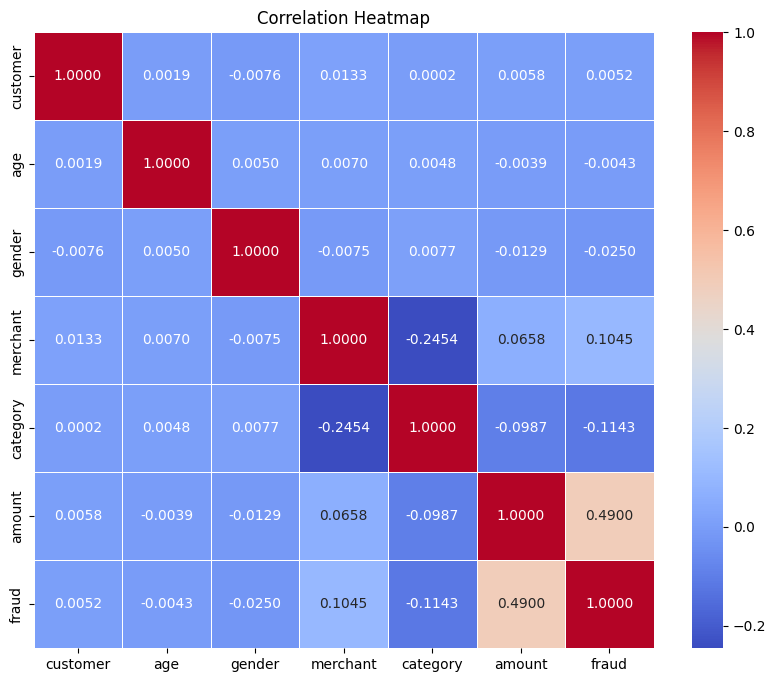

In [13]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

It seems that the most important features are:

- amount
- category
- merchant
- gender

Actually merchant and customer doesn't seem important in the dataset (merchant: 'M1823072687'  50%; 'M348934600'  35%; Other (89524)  15%).
So we decide to take: 

- amount
- category
- gender
- age

In [14]:
df.drop(columns=['customer'], inplace=True)
df.drop(columns=['merchant'], inplace=True)

In [15]:
print(df.head())

   age  gender  category  amount  fraud
0    4       2        12    4.55      0
1    2       2        12   39.68      0
2    4       1        12   26.89      0
3    3       2        12   17.25      0
4    5       2        12   35.72      0
